[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/crunchdao/adialab-notebooks/blob/main/boruta_feature_selection.ipynb)

# 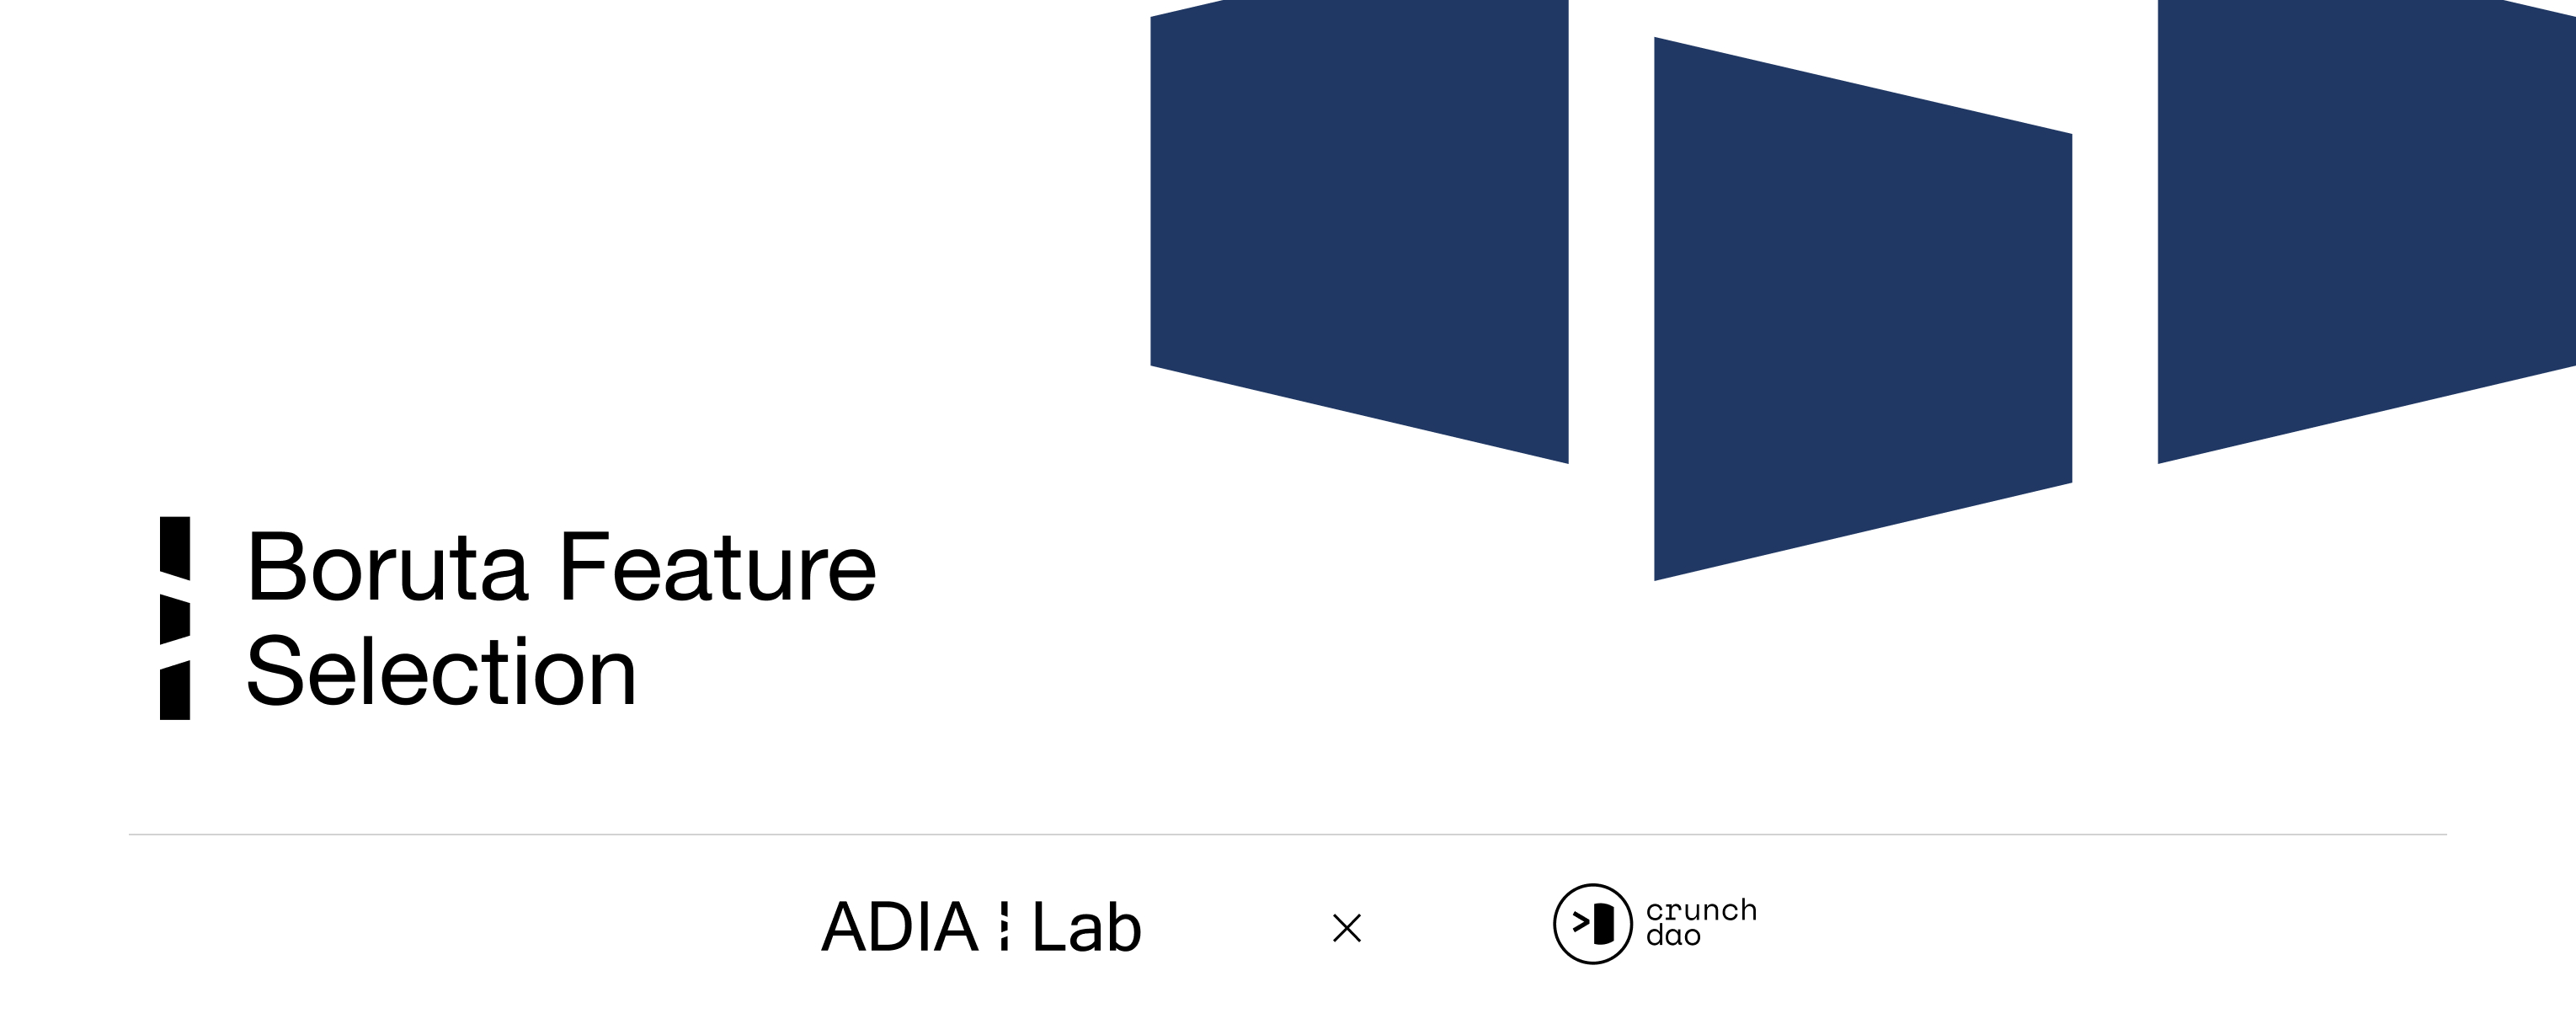

## ADIA Lab Market Prediction Competition - Tutorial Notebook 3

The notebook shown here is another version of the basic submission notebook. The method differs in that a feature selection step based on Boruta's method is added before the training step.

## Set up your crunch workspace

#### STEP 1
Run this cell to install the crunch library in your workspace.

In [ ]:
!pip3 install crunch-cli --upgrade

#### STEP 2
Import the crunch package and instantiate it to be able to access its functionality.

In [ ]:
import crunch
crunch = crunch.load_notebook(__name__)

#### STEP 3
Go to your submit page and copy paste your setup command to access the data https://adialab.crunchdao.com/submit

In [ ]:
%pip install crunch-cli --upgrade
!crunch --notebook setup resonant-poincare --token FMt1nrrKy61iFCRoucQxds6brAWMv7OFwleIEO25ShQNJW85DwHMdlzdz7l9DsQb
%cd resonant-poincare

In [ ]:
import pandas as pd
import numpy as np
import typing
import joblib
import json
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor

## Feature selection

Feature selection is the process of identifying and selecting a subset of input variables that are most relevant to predict the target variable. A way to apply feature selection to a dataset is Boruta's method. We choose to use RandomForestRegressor to do the feature selection. The method is described as follows:
- First, we create the shadow features randomly shuffing existing ones from Xtrain. In this way we obtain a subset of features whose data generating process is purely white (Gaussian) noise. In this notebook, a batch of dates, identifying cross-sectional representation of the system, are preprocessed together. In fact, in this example, the fitness function of the regressor is not compute on a minibatch, but on individual entries of the dataset. In a context in which the fitness is a function of a minibatch, the shadow features can be generated cross-sectionally.
- Then, we apply RandomForestRegressor to the dataset composed of both the features of Xtrain and the shadow features. We get an importance score for each feature and for each shadow feature.
- Finally, the features of Xtrain with a lower importance score than the maximum one among the shadow features are removed from the dataset.
- We iterate until the number of original features in Xtrain converges.

The three following functions are used to set up the above method.

In [ ]:
np.random.seed(42)

def get_X_boruta(X_train):
    X_shadow = X_train.apply(np.random.permutation)
    X_shadow.columns = ['shadow_' + feat for feat in X_train.columns]
    X_boruta = pd.concat([X_train, X_shadow], axis=1)
    return X_boruta

def get_random_bar(X_boruta, y, X_train, model):
    model.fit(X_boruta, np.array(y).ravel())
    feat_imp_X = model.feature_importances_[:len(X_train.columns)]
    feat_imp_shadow = model.feature_importances_[len(X_train.columns):]
    hits = feat_imp_X > feat_imp_shadow.max()
    return feat_imp_X, feat_imp_shadow, hits

def get_relevant_features(X_train, hits):
    features = X_train.columns.values
    relevant_features = []
    for index, value in enumerate(hits):
        if value == True:
            relevant_features.append(features[index])
    return relevant_features

The two following functions aim to store the names of the selected features in a json file and load it back during the prediction step.

In [ ]:
def store_list_as_json(data_list, folder_path, file_name):
    json_data = json.dumps(data_list)
    file_path = folder_path + "/" + file_name
    with open(file_path, "w") as json_file:
        json_file.write(json_data)
        
        
def read_json_file(file_path):
    with open(file_path, "r") as json_file:
        json_data = json_file.read()
    data_list = json.loads(json_data)
    return data_list

## Train and prediction steps

As the dataset contains a huge amount of data, we decided to cut it down to the last 100 dates available in Xtrain. The number of selected dates is represented by the variable n_cut. You are free to change it, but be careful not to exceed the CPU hours assigned to you.

In [ ]:
def train(X_train: pd.DataFrame, y_train: pd.DataFrame, model_directory_path: str = "resources") -> None:
    """
    Do your model training here.
    At each retrain this function will have to save an updated version of
    the model under the model_directiory_path, as in the example below.
    Note: You can use other serialization methods than joblib.dump(), as
    long as it matches what reads the model in infer().
    
    Args:
        X_train, y_train: the data to train the model.
        model_directory_path: the path to save your updated model
    
    Returns:
        None
    """
    
    # Cutting the dataset to the last n_cut dates.
    n_cut = 5
    
    cut_df_X = X_train[X_train['date'] >= int(len(X_train['date'].unique()) - n_cut)]
    cut_df_y = y_train[y_train['date'] >= int(len(y_train['date'].unique()) - n_cut)]
    
    X_train = cut_df_X.drop(columns=['id', 'date'])
    y_train = cut_df_y.drop(columns=['id', 'date'])
    
    
    # Feature selection step
    model = RandomForestRegressor(n_estimators=30, max_depth=3, n_jobs=30, random_state=42)
    
    n_iter = 100
    n_relevant_features = [len(X_train.columns)]

    rel_Xtrain = X_train.copy()

    for i in range(1,n_iter+1):
        X_boruta = get_X_boruta(rel_Xtrain)
        feat_importance_X, feat_importance_shadow, hits = get_random_bar(X_boruta, y_train, rel_Xtrain, model)
        relevant_features = get_relevant_features(rel_Xtrain, hits)
        n_relevant_features.append(len(relevant_features))
        rel_Xtrain = rel_Xtrain.loc[:,relevant_features]
        if n_relevant_features[i] == n_relevant_features[i-1]:
            break
    
    relevant_features = rel_Xtrain.columns.to_list()
    relevant_features.insert(0, 'date')
    relevant_features.insert(0,'id')
    
    # Saving the selected features in 'resources' file
    print("saving the selected features")
    folder_path = 'resources'
    file_name = 'selected_feat.json'
    store_list_as_json(relevant_features, folder_path, file_name)
    
    # Training the model
    print("training...")
    model.fit(rel_Xtrain, np.array(y_train).ravel())
    print(model)
    
    # Saving the model in 'resources' file
    model_directory_path = 'resources'
    model_pathname = Path(model_directory_path) / "model.joblib"
    print(f"Saving model in {model_pathname}")
    joblib.dump(model, model_pathname)
    

    
def infer(X_test: pd.DataFrame,
          model_directory_path: str = "resources") -> pd.DataFrame:
    """
    Do your inference here.
    This function will load the model saved at the previous iteration and use
    it to produce your inference on the current date.
    It is mandatory to send your inferences with the ids so the system
    can match it correctly.
    
    Args:
        model_directory_path: the path to the directory to the directory in wich we will be saving your updated model.
        X_test: the independant  variables of the current date passed to your model.

    Returns:
        A dataframe (date, id, value) with the inferences of your model for the current date.
    """
    
    # Loading the selected features
    file_path = "resources/selected_feat.json"
    selected_features = read_json_file(file_path)
    
    # Loading the model saved by the train function at previous iteration
    model = joblib.load(Path(model_directory_path) / "model.joblib")
    
    # Creating the predicted label dataframe with correct dates and ids
    X_test = X_test[selected_features]
    y_test_predicted = X_test[["date", "id"]].copy()
    y_test_predicted["value"] = model.predict(X_test.iloc[:, 2:])

    return y_test_predicted

## Testing your model locally

This last part of the notebook is not necessary for the submission but only for you, to analyze your model.

In [ ]:
from scipy.stats import spearmanr

In [ ]:
# Getting the data
X_train, y_train, X_test = crunch.load_data()

To have a preliminary assessment of our solution above we need to create train and test data:

In [ ]:
def temporal_train_test_split(X_train_loc, y_train_loc, test_size=0.2):
    unique_dates = X_train_loc.date.unique()
    split_date = unique_dates[int(len(unique_dates)*(1-test_size))]
    X_train_local = X_train_loc[X_train_loc['date'] <= split_date]
    X_test_local = X_train_loc[X_train_loc['date'] > split_date]
    
    y_train_local = y_train_loc[y_train_loc['date'] <= split_date]
    y_test_local = y_train_loc[y_train_loc['date'] > split_date]
    
    return X_train_local, X_test_local, y_train_local, y_test_local

In [ ]:
print("Splitting (X_train, y_train) in X_train_local, X_test_local, y_train_local, y_test_local")
X_train_local, X_test_local, y_train_local, y_test_local = temporal_train_test_split(
    X_train,
    y_train,
    test_size=0.2,)

In [ ]:
# Training. It may take a few minutes.
train(X_train_local, y_train_local)

In [ ]:
print("Inference")
y_test_local_pred = infer(X_test_local, model_directory_path="resources")
score = spearmanr(y_test_local["y"], y_test_local_pred["value"])[0] * 100
print(f"Spearman's correlation {score}")

## Testing your submission **locally**

This function of the crunch package will run your code locally, in the same way in which the function is called in the cloud (ie: one date at a time). If it runs without problem, it is highly likely that there won't be problems when executing it on the CrunchDAO's system, on the cloud.

You can setup the a retraining frequency as you which. A train frequency of 2 means that the system will retrain your model every two dates.

`force_first_train=True` means that your model will be trained on the first date of the test set.

In [ ]:
print("Remove unused data to release memory")
del X_train, y_train, X_test, X_train_local, X_test_local, y_train_local, y_test_local

In [ ]:
crunch.test(force_first_train=True, train_frequency=2)